In [1]:
import pandas as pd
import numpy as np
import pickle
import time

from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image

- 워드클라우드 준비(설치)

In [ ]:
## Mecab 설치

!pip install konlpy
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git 
%cd Mecab-ko-for-Google-Colab/
!bash install_mecab-ko_on_colab190912.sh
%cd ../

     |████████████████████████████████| 19.4 MB 7.6 MB/s 
     |████████████████████████████████| 448 kB 61.6 MB/s 
Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 109 (delta 7), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (109/109), 1.27 MiB | 14.61 MiB/s, done.
Resolving deltas: 100% (46/46), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2022-03-29 06:27:20--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::3403:4be7, 2406:da00:ff00::22c0:3470, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Loc

In [ ]:
stopwords1 = pd.read_csv('/content/drive/MyDrive/도서추천시스템/data/전처리 및 EDA/한국어불용어.txt', sep = '\t', header = 0)
stopwords=[]
for i in stopwords1['1']:
    stopwords.append(i)

In [ ]:
from konlpy.tag import Mecab
mecab = Mecab()

In [ ]:
book1 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템_2/검색 및 추천시스템/book1_drop.pkl')
book1 = book1[['isbn13','author','text']]
book1.columns = ['isbn','author','text']
book1.head(2)

,isbn,author,text
0,9791190710343,버지니아 울프,시대를 뛰어넘어 진정한 페미니즘 비평의 장을 연 고전. 거턴 대학과 뉴넘 대학에서 ...
1,9791190710350,제인 오스틴,"앤의서재 여성작가 클래식 2권. 지금으로부터 200년 전, 여자가 글을 쓰는 것도 ..."


In [ ]:
# colab 폰트 오류
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
re = pd.read_pickle('recommend_cat_new_pred.pkl')
re = re.reset_index()
re = re.drop(columns = ['index','level_0'])
re.head()

,isbn,title,categoryName,salesPoint,adult,rank,genres,mood,interest,rank_pred
0,9791165341909,달러구트 꿈 백화점 (50만 부 기념 드림 에디션) - 주문하신 꿈은 매진입니다,소설,379054,False,8,"[역사, 동화, 로맨스, 미스터리, 판타지, 무협]","[행복, 위로]","[일기, 동물, 사랑, 생각, 진로, 설득]",8.0
1,9791161571188,불편한 편의점 (40만부 기념 벚꽃 에디션),소설,330837,False,10,"[시대, 동화]","[위로, 힐링, 행복]","[시간, 심리, 관계, 사랑, 생각]",10.0
2,9791192186313,시맨틱 에러 포토에세이,에세이,242520,False,10,[판타지],[위로],"[사랑, 청춘, 영화, 사진]",10.0
3,9788954681179,밝은 밤 (별밤 에디션),소설,204554,False,10,"[예술, 동화, 로맨스]","[행복, 위로, 열정]","[사랑, 생각, 인생, 청춘, 관계, 시간, 가족]",10.0
4,9791165343729,달러구트 꿈 백화점 2 - 단골손님을 찾습니다,소설,191493,False,9,"[동화, 로맨스, 미스터리, 판타지, 무협]","[행복, 위로]","[사랑, 생각, 인생]",9.0


In [3]:
books_all = pd.read_pickle('books_all.pkl')
books_all = books_all[['isbn','rank_mean', 'review_title', 'review_id', 'review_rank',
        'review_text', 'rank_percentage']]
books_all.head(2)

,isbn,rank_mean,review_title,review_id,review_rank,review_text,rank_percentage
0,9791190710343,9.4,자기만의 방 - 버지니아 울프의 여성에세이,s*****0,5.0,\n\n \n시대를 뛰어넘어 진정한 페미니즘 비평의 장을 연 고전 <자기만의 방>은...,"[67%, 33%, 0%, 0%, 0%]"
1,9791190710343,9.4,#여성에세이#자기만의 방,녹**다,5.0,\n\n \n자기만의 방 버지니아 울프의 작품이다.한시대를 살다간 그녀의 삶은 기발...,"[67%, 33%, 0%, 0%, 0%]"


- 검색 함수

In [4]:
# 관심있는 것
def category(카테고리):
    if 카테고리[0][0] != '선택없음':
        return (re['categoryName'][i] in 카테고리[0])
    else:
        return True

def genresand(장르):
    if 장르[0][0] == '선택없음':
        return True
    elif (len(장르[0]) == 1):
        return (장르[0][0] in re['genres'][i])
    elif (len(장르[0]) == 2):
        return (장르[0][0] in re['genres'][i]) & (장르[0][1] in re['genres'][i])


def moodand(감성):
    if 감성[0][0] == '선택없음':
        return True
    elif (len(감성[0]) == 1):
        return (감성[0][0] in re['mood'][i])
    elif (len(감성[0]) == 2):
        return (감성[0][0] in re['mood'][i]) & (감성[0][1] in re['mood'][i])

def interestand(관심사):
    if 관심사[0][0] == '선택없음':
        return True
    elif (len(관심사[0]) == 1):
        return (관심사[0][0] in re['interest'][i])
    elif (len(관심사[0]) == 2):
        return (관심사[0][0] in re['interest'][i]) & (관심사[0][1] in re['interest'][i])
    
def genresor(장르):
    if 장르[0][0] == '선택없음':
        return True
    elif (len(장르[0]) == 1):
        return (장르[0][0] in re['genres'][i])
    elif (len(장르[0]) == 2):
        return (장르[0][0] in re['genres'][i]) | (장르[0][1] in re['genres'][i])


def moodor(감성):
    if 감성[0][0] == '선택없음':
        return True
    elif (len(감성[0]) == 1):
        return (감성[0][0] in re['mood'][i])
    elif (len(감성[0]) == 2):
        return (감성[0][0] in re['mood'][i]) | (감성[0][1] in re['mood'][i])

def interestor(관심사):
    if 관심사[0][0] == '선택없음':
        return True
    elif (len(관심사[0]) == 1):
        return (관심사[0][0] in re['interest'][i])
    elif (len(관심사[0]) == 2):
        return (관심사[0][0] in re['interest'][i]) | (관심사[0][1] in re['interest'][i])

In [5]:
# 관심없는 것

def nogenresand(장르no):
    if 장르no[0][0] == '선택없음':
        return True
    elif (len(장르no[0]) == 1):
        return (장르no[0][0] not in re['genres'][i])
    elif (len(장르no[0]) == 2):
        return (장르no[0][0] not in re['genres'][i]) & (장르no[0][1] not in re['genres'][i])


def nomoodand(감성no):
    if 감성no[0][0] == '선택없음':
        return True
    elif (len(감성no[0]) == 1):
        return (감성no[0][0] not in re['mood'][i])
    elif (len(감성no[0]) == 2):
        return (감성no[0][0] not in re['mood'][i]) & (감성no[0][1] not in re['mood'][i])

def nointerestand(관심사no):
    if 관심사no[0][0] == '선택없음':
        return True
    elif (len(관심사no[0]) == 1):
        return (관심사no[0][0] not in re['interest'][i])
    elif (len(관심사no[0]) == 2):
        return (관심사no[0][0] not in re['interest'][i]) & (관심사no[0][1] not in re['interest'][i])

- 협업필터링_1 함수

In [6]:
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook

def get_rmse(R, P, Q, non_zeros):
    error = 0
    # 두개의 분해된 행렬 P와 Q.T의 내적 곱으로 예측 R 행렬 생성
    full_pred_matrix = np.dot(P, Q.T)
    
    # 실제 R 행렬에서 널이 아닌 값의 위치 인덱스 추출하여 실제 R 행렬과 예측 행렬의 RMSE 추출
    x_non_zero_ind = [non_zero[0] for non_zero in non_zeros]
    y_non_zero_ind = [non_zero[1] for non_zero in non_zeros]
    R_non_zeros = R[x_non_zero_ind, y_non_zero_ind]
    
    full_pred_matrix_non_zeros = full_pred_matrix[x_non_zero_ind, y_non_zero_ind]
    
    mse = mean_squared_error(R_non_zeros, full_pred_matrix_non_zeros)
    rmse = np.sqrt(mse)
    
    return rmse

In [7]:
def matrix_factorization(R, K, steps=200, learning_rate=0.01, r_lambda = 0.01):
    num_users, num_items = R.shape
    # P와 Q 매트릭스의 크기를 지정하고 정규분포를 가진 랜덤한 값으로 입력합니다. 
    np.random.seed(1)
    P = np.random.normal(scale=1./K, size=(num_users, K))
    Q = np.random.normal(scale=1./K, size=(num_items, K))

    break_count = 0
       
    # R > 0 인 행 위치, 열 위치, 값을 non_zeros 리스트 객체에 저장. 
    non_zeros = [ (i, j, R[i,j]) for i in range(num_users) for j in range(num_items) if R[i,j] > 0 ]
   
    # P와 Q 매트릭스를 계속 업데이트(확률적 경사하강법)
    for step in tqdm_notebook(range(steps)):
        for i, j, r in non_zeros:
            # 실제 값과 예측 값의 차이인 오류 값 구함
            eij = r - np.dot(P[i, :], Q[j, :].T)
            # Regularization을 반영한 SGD 업데이트 공식 적용
            P[i,:] = P[i,:] + learning_rate*(eij * Q[j, :] - r_lambda*P[i,:])
            Q[j,:] = Q[j,:] + learning_rate*(eij * P[i, :] - r_lambda*Q[j,:])
       
        rmse = get_rmse(R, P, Q, non_zeros)
        if (step % 10) == 0 :
            print("### iteration step : ", step," rmse : ", rmse)
            
    return P, Q

- 협업필터링_2 함수
(userid에 추천)

In [8]:
def get_unseen_books(ratings_matrix, userId):
    # userId로 입력받은 사용자의 모든 도서정보 추출하여 Series로 반환함. 
    # 반환된 user_rating 은 도서명(title)을 index로 가지는 Series 객체임. 
    user_rating = ratings_matrix.loc[userId,:]
    
    # user_rating이 0보다 크면 기존에 관람한 영화임. 대상 index를 추출하여 list 객체로 만듬
    already_seen = user_rating[ user_rating > 0].index.tolist()
    
    # 모든 영화명을 list 객체로 만듬. 
    books_list = ratings_matrix.columns.tolist()
    
    # list comprehension으로 already_seen에 해당하는 book은 books_list에서 제외함. 
    unseen_list = [ book for book in books_list if book not in already_seen]
    
    return unseen_list

In [9]:
def recomm_book_by_userid(pred_df, userId, unseen_list, top_n=10):
    # 예측 평점 DataFrame에서 사용자id index와 unseen_list로 들어온 영화명 컬럼을 추출하여
    # 가장 예측 평점이 높은 순으로 정렬함. 
    recomm_books = pred_df.loc[userId, unseen_list].sort_values(ascending=False)[:top_n]
    # loc[행:열] 데이터 찾아, top_n 까지 내림차순으로 정렬
    return recomm_books

In [10]:
# 1. 검색 --------------------------------------------------------------------------------------------
카테고리 = []
장르 = []
감성 = []
관심사 = []
성인 = []
장르no = []
감성no = []
관심사no = []
성인no = []
userid = []

userid질문 = input('회원이십니까? : 네 / 아니요\n')
if userid질문 == '네':
    userid.append(input('\n아이디를 입력해주세요 : \n'))
    성인질문 = input('\n성인입니까? : 네 / 아니요\n')
else:
    성인질문 = input('\n성인입니까? : 네 / 아니요\n')

if 성인질문 == '네':
    성인.append([True,False])
    카테고리.append(input("\n원하시는 분야를 입력해주세요 : \n소설 / 에세이 / 자기계발 / 시 / 희곡 / 선택없음\n").split())
    장르.append(input('\n책을 읽을 때 선호하는 장르가 있나요? : \n시대 / 역사 / 철학 / 로맨스 / 전쟁 /  미스터리 / 예술 /  판타지 / 자서전 / 동화 / 과학 / 무협 / 선택없음\n').split())
    장르no.append(input('\n원하지 않는 장르를 입력해주세요 : \n').split())
    감성.append(input('\n어떤 감성의 책을 원하세요? : \n고민 / 열정 / 도전 / 긍정 / 후회 / 행복 / 우울 / 위로 / 고통 / 자유 /\
                    \n희망 / 슬픔 / 열망 / 비극 / 불안 / 용기 / 절망 / 불행 / 유머 / 힐링 / 선택없음\n').split())
    감성no.append(input('\n원하지 않는 감성를 입력해주세요 : \n').split())
    관심사.append(input('\n요즘 관심있는 것이 무엇인가요? : \n리더십 / 시간 / 페미니즘 / 취업 / 진로 / 비즈니스 / 설득 / 건강 / 심리 / 시 / 희곡 /\
                    \n가족 / 관계 / 동물 / 사진 / 그림 / 여행 / 미술 / 영화 / 음악 / 음식 / 일기 / 자연 /\
                    \n종교 / 사랑 / 인간 / 생각 / 사회 / 인생 / 일상 / 친구 / 성공 / 청춘 / 정치 / 취미 / 스포츠 / 선택없음\n').split())
    관심사no.append(input('\n원하지 않는 관심사를 입력해주세요 : \n').split())
elif 성인질문 == '아니요':
    성인.append([False])
    카테고리.append(input("\n원하시는 분야를 입력해주세요 : \n소설 / 에세이 / 자기계발 / 시 / 희곡 / 선택없음\n").split())
    장르.append(input('\n책을 읽을 때 선호하는 장르가 있나요? : \n시대 / 역사 / 철학 / 로맨스 / 전쟁 /  미스터리 / 예술 /  판타지 / 자서전 / 동화 / 과학 / 무협 / 선택없음\n').split())
    장르no.append(input('\n원하지 않는 장르를 입력해주세요 : \n').split())
    감성.append(input('\n어떤 감성의 책을 원하세요? : \n고민 / 열정 / 도전 / 긍정 / 후회 / 행복 / 우울 / 위로 / 고통 / 자유 /\
                    \n희망 / 슬픔 / 열망 / 비극 / 불안 / 용기 / 절망 / 불행 / 유머 / 힐링 / 선택없음\n').split())
    감성no.append(input('\n원하지 않는 감성를 입력해주세요 : \n').split())
    관심사.append(input('\n요즘 관심있는 것이 무엇인가요? : \n리더십 / 시간 / 페미니즘 / 취업 / 진로 / 비즈니스 / 설득 / 건강 / 심리 / 시 / 희곡 /\
                    \n가족 / 관계 / 동물 / 사진 / 그림 / 여행 / 미술 / 영화 / 음악 / 음식 / 일기 / 자연 /\
                    \n종교 / 사랑 / 인간 / 생각 / 사회 / 인생 / 일상 / 친구 / 성공 / 청춘 / 정치 / 취미 / 스포츠 / 선택없음\n').split())
    관심사no.append(input('\n원하지 않는 관심사를 입력해주세요 : \n').split())

select_list_and = []
for i in range(len(re)):
    if (re['adult'][i] in 성인[0]) & category(카테고리) & genresand(장르) & moodand(감성) & interestand(관심사)\
    & nogenresand(장르no) & nomoodand(감성no) & nointerestand(관심사no) :
        select_list_and.append(re.loc[i])
        
select_book_and = pd.DataFrame(select_list_and)

select_list_or = []
for i in range(len(re)):
    if (re['adult'][i] in 성인[0]) & category(카테고리) & genresor(장르) & moodor(감성) & interestor(관심사)\
    & nogenresand(장르no) & nomoodand(감성no) & nointerestand(관심사no):
        select_list_or.append(re.loc[i])
        
select_book_or = pd.DataFrame(select_list_or)

if len(select_book_and) >= 20:
    a = select_book_and
else:
    a = select_book_or

%time
# 2. 가중평점 --------------------------------------------------------------------------------------------

# 가중평점
# 상위 60%에 해당하는 rank를 최소 투표 횟수인 m으로 지정
C = re['salesPoint'].mean()
m = re['rank'].quantile(0.6)

def weighted_score_average(record):
    v = record['rank']
    R = record['salesPoint']
    
    return ( (v/(v+m)) * R ) + ( (m/(m+v)) * C )

# 기존 데이터에 가중평점 칼럼 추가
a['weighted_score'] = re.apply(weighted_score_average, axis=1)
a = a.sort_values('weighted_score', ascending = False)
a = a.head(100)


# 3-1. 협업필터링 --------------------------------------------------------------------------------------------

b = pd.merge(a, books_all, on = 'isbn')
ratings_matrix = b.pivot_table('review_rank', index='review_id', columns='title')


%time
# 경사하강법을 이용한 행렬 분해
P, Q = matrix_factorization(ratings_matrix.values, K=50, steps=300, learning_rate=0.01, r_lambda = 0.01)
# K=50 잠재요인, steps=200: 200번 반복 수행, learning rate: 학습률, r_lambda: L2 규제 계수

pred_matrix = np.dot(P, Q.T) # 행렬의 곱(내적)

ratings_pred_matrix = pd.DataFrame(data=pred_matrix, index= ratings_matrix.index,
                                   columns = ratings_matrix.columns)
ratings_matrix_T = ratings_pred_matrix.transpose()

# 도서들 간 코사인 유사도 산출
item_sim = cosine_similarity(ratings_matrix_T, ratings_matrix_T)

# cosine_similarity() 로 반환된 넘파이 행렬을 도서명을 매핑하여 DataFrame으로 변환
item_sim_df = pd.DataFrame(data=item_sim, index=ratings_pred_matrix.columns,
                          columns=ratings_pred_matrix.columns)

sim_books = []

for i in range(3):
    try:
        sim_book = item_sim_df[a.loc[a.head(3).index[i]]['title']].sort_values(ascending=False)[0:3]
        sim_books.append(sim_book)
    except:
        pass
sim_books_1 = pd.DataFrame(sim_books)

col = sim_books_1.columns
sim_list = []
for i in col:
    for j in a.index:
        if a['title'][j] == i:
            sim_list.append(a.loc[j])
sim_list_df = pd.DataFrame(sim_list)

# sim_list_df : 협업필터링3-1 결과

# ---------------------------------------------------------------------------------------------------------------

# 3-2 userid 추천
# 사용자가 관람하지 않는 도서명 추출
try:   
    unseen_list = get_unseen_books(ratings_matrix, userid[0])
  # 잠재 요인 협업 필터링으로 도서 추천 
    recomm_books = recomm_book_by_userid(ratings_pred_matrix, userid[0], unseen_list, top_n=10)
    # 평점 데이타를 DataFrame으로 생성. 
    recomm_books = pd.DataFrame(data=recomm_books.values,index=recomm_books.index,columns=['pred_score'])
    recomm_books = recomm_books[recomm_books['pred_score'] > 1]

    cols2 = recomm_books.index

    recomm_list = []
    for i in cols2:
    for j in a.index:
    if a['title'][j] == i:
        recomm_list.append(a.loc[j])
    recomm_list_df = pd.DataFrame(recomm_list)

except:
    pass
# recomm_books : 협업필터링3-2 결과

# user 정보가 있으면 3-1 결과 output, 없으면 3-2 결과 output
if userid질문 == '아니요':
    recommend = sim_list_df
else: # userid질문 == '예'
    try:
        recommend = recomm_list_df
    except:
        recommend = sim_list_df

recommend

# ---------------------------------------------------------------------------------------------------------------
# 워드클라우드

word = pd.merge(recommend,book1, on='isbn')
word['text'] = word['text'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]',' ')
words_all = []
results = []

for i in word['text']:
    text = mecab.morphs(i)
    
    r=[]
    for te in text:
        r.append(te)
        words_all.append(te)
    rl = (" ".join(r)).strip() # 문장 하나 하나
    results.append(rl) # 모든 문장 append

wordclound = []
for se in results:
    result1 = []
    for w in se.split(' '):
      if w not in stopwords:
          result1.append(w)
    wordclound.append(result1)

gen_list = [] 
W, H = (100,50) 
font_path = 'NanumBarunGothic'
for clound in wordclound:
  mask = np.array(Image.open('/content/drive/MyDrive/도서추천시스템_2/검색 및 추천시스템/cloud.png'))
  wc = WordCloud(font_path=font_path, background_color="white", width=W*10,height=H*10, mask=mask)
  c = Counter(clound) # 위에서 얻은 words를 처리하여 단어별 빈도수 형태의 딕셔너리 데이터를 구함
  gen = wc.generate_from_frequencies(c)
  gen_list.append(gen)

recommend

회원이십니까? : 네 / 아니요
네

아이디를 입력해주세요 : 
나*

성인입니까? : 네 / 아니요
네

원하시는 분야를 입력해주세요 : 
소설 / 에세이 / 자기계발 / 시 / 희곡 / 선택없음
소설 에세이

책을 읽을 때 선호하는 장르가 있나요? : 
시대 / 역사 / 철학 / 로맨스 / 전쟁 /  미스터리 / 예술 /  판타지 / 자서전 / 동화 / 과학 / 무협 / 선택없음
역사

원하지 않는 장르를 입력해주세요 : 
선택없음

어떤 감성의 책을 원하세요? : 
고민 / 열정 / 도전 / 긍정 / 후회 / 행복 / 우울 / 위로 / 고통 / 자유 /                    
희망 / 슬픔 / 열망 / 비극 / 불안 / 용기 / 절망 / 불행 / 유머 / 힐링 / 선택없음
희망 열정

원하지 않는 감성를 입력해주세요 : 
우울

요즘 관심있는 것이 무엇인가요? : 
리더십 / 시간 / 페미니즘 / 취업 / 진로 / 비즈니스 / 설득 / 건강 / 심리 / 시 / 희곡 /                    
가족 / 관계 / 동물 / 사진 / 그림 / 여행 / 미술 / 영화 / 음악 / 음식 / 일기 / 자연 /                    
종교 / 사랑 / 인간 / 생각 / 사회 / 인생 / 일상 / 친구 / 성공 / 청춘 / 정치 / 취미 / 스포츠 / 선택없음
가족

원하지 않는 관심사를 입력해주세요 : 
종교
Wall time: 0 ns
Wall time: 0 ns


<ipython-input-7-e777c377681d>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step in tqdm_notebook(range(steps)):


  0%|          | 0/300 [00:00<?, ?it/s]

### iteration step :  0  rmse :  4.747354423911032
### iteration step :  10  rmse :  4.658792276511268
### iteration step :  20  rmse :  3.363273294770356
### iteration step :  30  rmse :  1.333538744641374
### iteration step :  40  rmse :  0.7624097258018965
### iteration step :  50  rmse :  0.48982433098032924
### iteration step :  60  rmse :  0.30482763489932757
### iteration step :  70  rmse :  0.16546996736827235
### iteration step :  80  rmse :  0.07691454106081559
### iteration step :  90  rmse :  0.03669547385095683
### iteration step :  100  rmse :  0.023788970288261664
### iteration step :  110  rmse :  0.020330240235806762
### iteration step :  120  rmse :  0.019040586719156077
### iteration step :  130  rmse :  0.018275817434939893
### iteration step :  140  rmse :  0.01771588313001171
### iteration step :  150  rmse :  0.017277840021334232
### iteration step :  160  rmse :  0.016927669549851577
### iteration step :  170  rmse :  0.016645583310810105
### iteration step :  1

NameError: name 'book1' is not defined

In [ ]:
recommend

In [11]:
userid, 성인, 카테고리, 장르, 장르no, 감성, 감성no, 관심사, 관심사no

(['나*'],
 [[True, False]],
 [['소설', '에세이']],
 [['역사']],
 [['선택없음']],
 [['희망', '열정']],
 [['우울']],
 [['가족']],
 [['종교']])

# 코드 확인

## 1. 검색결과

In [12]:
select_list_and = []
for i in range(len(re)):
    if (re['adult'][i] in 성인[0]) & category(카테고리) & genresand(장르) & moodand(감성) & interestand(관심사)\
    & nogenresand(장르no) & nomoodand(감성no) & nointerestand(관심사no) :
        select_list_and.append(re.loc[i])
        
select_book_and = pd.DataFrame(select_list_and)

select_list_or = []
for i in range(len(re)):
    if (re['adult'][i] in 성인[0]) & category(카테고리) & genresor(장르) & moodor(감성) & interestor(관심사)\
    & nogenresand(장르no) & nomoodand(감성no) & nointerestand(관심사no):
        select_list_or.append(re.loc[i])
        
select_book_or = pd.DataFrame(select_list_or)

if len(select_book_and) >= 20:
    a = select_book_and
else:
    a = select_book_or

a

,isbn,title,categoryName,salesPoint,adult,rank,genres,mood,interest,rank_pred
612,9788989258056,탈무드,에세이,12554,False,9,"[역사, 시대]","[긍정, 희망, 열망, 열정, 행복, 고민, 후회]","[사랑, 인생, 청춘, 생각, 인간, 가족, 일상]",9.000000
851,9791191187564,엄마 박완서의 부엌 : 정확하고 완전한 사랑의 기억,에세이,9565,False,9,"[역사, 예술]","[행복, 위로, 열정, 고민, 후회, 희망, 용기, 힐링, 긍정, 자유, 열망]","[일기, 시간, 사랑, 생각, 심리, 인생, 청춘, 가족, 음식]",9.000000
1071,9788959136612,오늘 내가 살아갈 이유 - 운명조차 빼앗아가지 못한 '영혼의 기록',에세이,7995,False,9,"[역사, 동화]","[고통, 슬픔, 비극, 절망, 불행, 행복, 열정, 고민, 후회, 긍정, 위로, 희...","[가족, 일기, 생각, 사랑, 인생, 청춘, 시간]",9.000000
1427,9788954671828,사랑의 역사,소설,6141,False,9,"[역사, 동화]","[행복, 위로, 열정, 도전, 후회, 희망, 용기]","[일기, 사랑, 생각, 인생, 청춘, 관계, 가족, 인간]",9.000000
1725,9791186757581,이렇게 될 줄 몰랐습니다,에세이,5201,False,9,"[동화, 역사]","[위로, 힐링, 행복, 열정, 고민, 후회, 유머, 희망, 불행]","[가족, 동물, 사진, 그림, 일기, 사랑, 생각, 인생, 청춘, 시간, 여행, 일...",9.000000
...,...,...,...,...,...,...,...,...,...,...
44638,9788967641696,치유의 시학,소설,38,False,0,"[역사, 예술]","[고민, 자유, 열정, 희망, 열망, 비극, 불행, 위로, 힐링]","[심리, 관계, 시, 사랑, 인생, 인간, 자연, 리더십, 비즈니스, 일상, 가족]",8.532278
51098,9791163895930,8년에 걸친 신부 - 그대가 눈을 뜨면,소설,23,False,9,[역사],"[힐링, 행복, 열정, 도전, 후회, 희망, 용기, 불행, 긍정]","[가족, 일기, 생각, 사랑, 인생, 청춘, 영화, 진로, 성공, 건강]",9.000000
52075,9788984012127,히믈러의 요리사,소설,22,False,0,"[시대, 역사]","[행복, 위로, 고통, 비극, 불행, 열정, 희망]","[가족, 사랑, 생각, 인생, 청춘, 일상, 음식, 성공]",8.612714
53028,9788963272528,금강 15 - 제5부 우리 무엇이 되어 다시 만나랴,소설,20,False,0,"[시대, 예술, 역사, 동화, 로맨스]","[행복, 열정, 도전, 희망, 열망, 용기, 절망, 불행]","[생각, 가족, 정치, 청춘, 사랑, 인생, 성공]",8.528978


## 2. 가중평점

In [13]:
# 가중평점
# 상위 60%에 해당하는 rank를 최소 투표 횟수인 m으로 지정
C = re['rank'].mean()
m = re['salesPoint'].quantile(0.6)

def weighted_score_average(record):
    v = record['salesPoint']
    R = record['rank']
    
    return ( (v/(v+m)) * R ) + ( (m/(m+v)) * C )

# 기존 데이터에 가중평점 칼럼 추가
a['weighted_score'] = re.apply(weighted_score_average, axis=1)
a = a.sort_values('weighted_score', ascending = False)
a = a.head(100)
a

,isbn,title,categoryName,salesPoint,adult,rank,genres,mood,interest,rank_pred,weighted_score
4938,9791185823638,마녀엄마 - 육아를 빙자한 마녀체력 엄마의 성장기록,에세이,1925,False,10,"[역사, 철학, 동화]","[열정, 도전, 행복, 위로, 용기, 후회, 희망, 불행]","[일기, 성공, 사랑, 생각, 가족, 인간, 인생, 시간, 페미니즘]",10.000000,9.507269
5295,9791162205808,완벽하게 사랑하는 너에게 : 뻔하지만 이 말밖엔,에세이,1793,False,10,"[동화, 역사]","[위로, 힐링, 행복, 열정, 고민, 후회, 희망, 용기]","[가족, 사진, 그림, 일기, 사랑, 생각, 인생, 청춘, 시간]",10.000000,9.475527
612,9788989258056,탈무드,에세이,12554,False,9,"[역사, 시대]","[긍정, 희망, 열망, 열정, 행복, 고민, 후회]","[사랑, 인생, 청춘, 생각, 인간, 가족, 일상]",9.000000,8.936093
851,9791191187564,엄마 박완서의 부엌 : 정확하고 완전한 사랑의 기억,에세이,9565,False,9,"[역사, 예술]","[행복, 위로, 열정, 고민, 후회, 희망, 용기, 힐링, 긍정, 자유, 열망]","[일기, 시간, 사랑, 생각, 심리, 인생, 청춘, 가족, 음식]",9.000000,8.916643
1071,9788959136612,오늘 내가 살아갈 이유 - 운명조차 빼앗아가지 못한 '영혼의 기록',에세이,7995,False,9,"[역사, 동화]","[고통, 슬픔, 비극, 절망, 불행, 행복, 열정, 고민, 후회, 긍정, 위로, 희...","[가족, 일기, 생각, 사랑, 인생, 청춘, 시간]",9.000000,8.900782
...,...,...,...,...,...,...,...,...,...,...,...
33074,9791165396916,나만 믿고 따라와 3,에세이,95,False,0,"[역사, 판타지, 동화]","[비극, 불행, 열정, 행복, 열망, 희망]","[가족, 일기, 사랑, 인생, 청춘, 여행, 시간, 성공]",9.148142,4.231780
28857,9788966372171,"암환자가 뭐 어때서 - 암환자의 아들이자 암환자의 남편, 그리고 암환자였던 한 남자...",에세이,135,False,0,"[역사, 동화]","[열정, 도전, 행복, 위로, 고민, 후회, 희망, 불행, 긍정, 열망, 용기, 절망]","[가족, 일기, 사랑, 생각, 시간, 인생, 청춘, 성공]",8.866337,3.798861
28464,9791137273665,뻔한 인생에서 숨은 나 찾기,에세이,140,False,0,"[동화, 역사, 예술]","[위로, 힐링, 행복, 슬픔, 열정, 도전, 긍정, 열망, 희망, 용기, 고민, 불행]","[사진, 그림, 일기, 사랑, 생각, 인생, 청춘, 가족, 일상, 취미, 시간, 성공]",9.003846,3.750896
28472,9791197151446,천 일의 순이 - 2021 문학나눔 선정 도서,에세이,140,False,0,"[역사, 시대, 자서전]","[고민, 행복, 후회, 열정, 도전, 희망, 열망, 용기, 절망]","[가족, 일기, 생각, 사회, 자연, 시간, 인생, 인간, 청춘]",9.257281,3.750896


## 3-1. 협업필터링
- 유저 id 없을 때

In [16]:
b = pd.merge(a, books_all, on = 'isbn')
ratings_matrix = b.pivot_table('review_rank', index='review_id', columns='title')

%time
# 경사하강법을 이용한 행렬 분해
P, Q = matrix_factorization(ratings_matrix.values, K=50, steps=300, learning_rate=0.01, r_lambda = 0.01)
# K=50 잠재요인, steps=200: 200번 반복 수행, learning rate: 학습률, r_lambda: L2 규제 계수

pred_matrix = np.dot(P, Q.T) # 행렬의 곱(내적)

ratings_pred_matrix = pd.DataFrame(data=pred_matrix, index= ratings_matrix.index,
                                   columns = ratings_matrix.columns)
ratings_matrix_T = ratings_pred_matrix.transpose()

# 도서들 간 코사인 유사도 산출
item_sim = cosine_similarity(ratings_matrix_T, ratings_matrix_T)

# cosine_similarity() 로 반환된 넘파이 행렬을 도서명을 매핑하여 DataFrame으로 변환
item_sim_df = pd.DataFrame(data=item_sim, index=ratings_pred_matrix.columns,
                          columns=ratings_pred_matrix.columns)

sim_books = []
noreviews=[]
for i in range(3):
    try:
        sim_book = item_sim_df[a.loc[a.head(3).index[i]]['title']].sort_values(ascending=False)[0:3]
        sim_books.append(sim_book)
    except:
        noreview = i
        noreviews.append(noreview)
sim_books_1 = pd.DataFrame(sim_books)

col = sim_books_1.columns
cols = []
for c in col:
    cols.append(c)
for d in noreviews:
    cols.append(a.loc[a.head(3).index[d]]['title'])


sim_list = []
for i in cols:
    for j in a.index:
        if a['title'][j] == i:
            sim_list.append(a.loc[j])
sim_list_df = pd.DataFrame(sim_list)

sim_list_df

Wall time: 0 ns


<ipython-input-7-e777c377681d>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step in tqdm_notebook(range(steps)):


  0%|          | 0/300 [00:00<?, ?it/s]

### iteration step :  0  rmse :  4.747354423911032
### iteration step :  10  rmse :  4.658792276511268
### iteration step :  20  rmse :  3.363273294770356
### iteration step :  30  rmse :  1.333538744641374
### iteration step :  40  rmse :  0.7624097258018965
### iteration step :  50  rmse :  0.48982433098032924
### iteration step :  60  rmse :  0.30482763489932757
### iteration step :  70  rmse :  0.16546996736827235
### iteration step :  80  rmse :  0.07691454106081559
### iteration step :  90  rmse :  0.03669547385095683
### iteration step :  100  rmse :  0.023788970288261664
### iteration step :  110  rmse :  0.020330240235806762
### iteration step :  120  rmse :  0.019040586719156077
### iteration step :  130  rmse :  0.018275817434939893
### iteration step :  140  rmse :  0.01771588313001171
### iteration step :  150  rmse :  0.017277840021334232
### iteration step :  160  rmse :  0.016927669549851577
### iteration step :  170  rmse :  0.016645583310810105
### iteration step :  1

,isbn,title,categoryName,salesPoint,adult,rank,genres,mood,interest,rank_pred,weighted_score
4938,9791185823638,마녀엄마 - 육아를 빙자한 마녀체력 엄마의 성장기록,에세이,1925,False,10,"[역사, 철학, 동화]","[열정, 도전, 행복, 위로, 용기, 후회, 희망, 불행]","[일기, 성공, 사랑, 생각, 가족, 인간, 인생, 시간, 페미니즘]",10.0,9.507269
28357,9788994040011,사랑이 떠나가면,소설,141,False,8,"[역사, 동화, 자서전]","[열정, 행복, 도전, 후회, 긍정, 위로, 희망, 열망, 용기, 절망]","[가족, 심리, 관계, 일기, 사랑, 인생, 청춘, 일상, 성공, 시간, 인간, 생...",8.0,6.582757
34640,9791130604381,십 년 후에 죽기로 결심한 아빠에게,에세이,84,False,9,"[역사, 시대, 동화, 자서전]","[행복, 열정, 고민, 후회, 희망, 불행]","[가족, 일기, 생각, 사랑, 인생, 청춘, 취업, 시간, 성공]",9.0,6.592219
5295,9791162205808,완벽하게 사랑하는 너에게 : 뻔하지만 이 말밖엔,에세이,1793,False,10,"[동화, 역사]","[위로, 힐링, 행복, 열정, 고민, 후회, 희망, 용기]","[가족, 사진, 그림, 일기, 사랑, 생각, 인생, 청춘, 시간]",10.0,9.475527
14951,9791162209028,완벽하게 사랑하는 너에게 : 뻔하지만 이 말밖엔 (기프트 에디션),에세이,486,False,9,"[동화, 역사]","[위로, 힐링, 슬픔, 행복, 열정, 고민, 후회, 희망, 용기, 불행]","[가족, 사진, 그림, 일기, 사랑, 생각, 인생, 청춘, 시간, 성공]",9.0,7.896704
29729,9788934940265,기적을 만든 천만번의 포옹 - 청각장애인이 명문대생이 되기까지,에세이,125,False,9,"[역사, 자서전]","[열정, 도전, 후회, 긍정, 행복, 위로, 희망, 열망, 용기, 절망]","[가족, 일기, 성공, 인생, 시간, 진로, 청춘]",9.0,6.851324
612,9788989258056,탈무드,에세이,12554,False,9,"[역사, 시대]","[긍정, 희망, 열망, 열정, 행복, 고민, 후회]","[사랑, 인생, 청춘, 생각, 인간, 가족, 일상]",9.0,8.936093
1071,9788959136612,오늘 내가 살아갈 이유 - 운명조차 빼앗아가지 못한 '영혼의 기록',에세이,7995,False,9,"[역사, 동화]","[고통, 슬픔, 비극, 절망, 불행, 행복, 열정, 고민, 후회, 긍정, 위로, 희...","[가족, 일기, 생각, 사랑, 인생, 청춘, 시간]",9.0,8.900782
9435,9788965743088,인생사용설명서 두 번째 이야기 - 내 삶을 희망으로 가득 채우는 일곱 가지 물음,에세이,916,False,9,"[역사, 시대, 동화]","[행복, 위로, 희망, 고민, 후회, 도전, 열정, 열망, 용기, 긍정, 절망]","[인간, 가족, 사랑, 생각, 사회, 인생, 시간, 성공, 청춘]",9.0,8.301497


In [ ]:
noreviews

[2]

## 3-2. 유저_id 입력 도서추천

In [ ]:
userid = ['나*']

In [ ]:
# 사용자가 관람하지 않는 도서명 추출   
unseen_list = get_unseen_books(ratings_matrix, userid[0])

# 잠재 요인 협업 필터링으로 도서 추천 
recomm_books = recomm_book_by_userid(ratings_pred_matrix, userid[0], unseen_list, top_n=9)

# 평점 데이타를 DataFrame으로 생성. 
recomm_books = pd.DataFrame(data=recomm_books.values,index=recomm_books.index,columns=['pred_score'])
recomm_books = recomm_books[recomm_books['pred_score'] > 1]
recomm_books

,pred_score
title,
모지스 할머니의 크리스마스 선물 - 해피 모지스마스!,2.502446
내 사랑 모드,2.298699
"온 마음을 다해 디저트 - 대단할 것 없지만, 위로가 되는 맛",2.202972
엄마 박완서의 부엌 : 정확하고 완전한 사랑의 기억,2.075160
"유일한, 평범 - 최현정의 마음 성장 에세이",2.027142
연을 쫓는 아이,1.994503
완벽하게 사랑하는 너에게 : 뻔하지만 이 말밖엔,1.854703
고등어를 금하노라 - 자유로운 가족을 꿈꾸는 이들에게 외치다,1.655239
김약국의 딸들 - 박경리 장편소설,1.641357


In [ ]:
cols2 = recomm_books.index

recomm_list = []
for i in cols2:
    for j in a.index:
        if a['title'][j] == i:
            recomm_list.append(a.loc[j])
recomm_list_df = pd.DataFrame(recomm_list)

recomm_list_df

,level_0,isbn,title,categoryName,salesPoint,adult,rank,genres,mood,interest,rank_pred,weighted_score
3513,3513,9791190382083,모지스 할머니의 크리스마스 선물 - 해피 모지스마스!,에세이,2762,False,10,"[동화, 역사, 판타지]","[후회, 행복, 열정, 도전, 위로, 희망, 용기, 힐링, 유머]","[시간, 생각, 사진, 그림, 일기, 사랑, 인생, 청춘, 일상]",10.0,9.643921
2958,2958,9791185823331,내 사랑 모드,에세이,3225,False,9,"[동화, 역사, 자서전]","[힐링, 행복, 열정, 후회, 위로, 희망, 용기, 불행]","[사진, 그림, 일기, 생각, 사랑, 인생, 청춘, 시간, 영화, 성공]",9.0,8.764825
8094,8094,9791160402759,"온 마음을 다해 디저트 - 대단할 것 없지만, 위로가 되는 맛",에세이,1114,False,9,"[역사, 동화]","[긍정, 희망, 행복, 위로, 열정, 후회, 불행]","[일기, 음식, 사랑, 생각, 인생, 청춘, 시간, 여행, 일상, 성공]",9.0,8.402449
851,851,9791191187564,엄마 박완서의 부엌 : 정확하고 완전한 사랑의 기억,에세이,9565,False,9,"[역사, 예술]","[행복, 위로, 열정, 고민, 후회, 희망, 용기, 힐링, 긍정, 자유, 열망]","[일기, 시간, 사랑, 생각, 심리, 인생, 청춘, 가족, 음식]",9.0,8.916643
9389,9389,9788950997908,"유일한, 평범 - 최현정의 마음 성장 에세이",에세이,923,False,10,"[역사, 동화, 자서전]","[행복, 위로, 고민, 후회, 희망, 용기]","[일기, 사랑, 생각, 일상, 인생, 가족, 청춘]",10.0,9.088511
339,339,9788972754824,연을 쫓는 아이,소설,18668,False,9,"[역사, 동화]","[힐링, 희망, 고민, 비극, 불행, 고통, 절망, 행복, 열정]","[생각, 사랑, 인생, 청춘, 심리]",9.0,8.956740
5295,5295,9791162205808,완벽하게 사랑하는 너에게 : 뻔하지만 이 말밖엔,에세이,1793,False,10,"[동화, 역사]","[위로, 힐링, 행복, 열정, 고민, 후회, 희망, 용기]","[가족, 사진, 그림, 일기, 사랑, 생각, 인생, 청춘, 시간]",10.0,9.475527
3781,3781,9788971848197,고등어를 금하노라 - 자유로운 가족을 꿈꾸는 이들에게 외치다,에세이,2545,False,9,"[시대, 역사, 동화]","[행복, 고민, 후회, 자유, 열망, 도전, 희망, 용기]","[가족, 생각, 사회, 인생, 시간, 인간, 청춘, 일상]",9.0,8.707731
1226,1226,9788960532625,김약국의 딸들 - 박경리 장편소설,소설,7104,False,9,"[시대, 역사]","[긍정, 희망, 열망, 비극, 불행, 열정, 도전, 용기, 절망]","[시간, 사랑, 인생, 인간, 청춘, 일상]",9.0,8.888771


# 워드클라우드

In [ ]:
recommend # 최종 추천 책

,level_0,isbn,title,categoryName,salesPoint,adult,rank,genres,mood,interest,rank_pred,weighted_score
93,93,9788932916194,창문 넘어 도망친 100세 노인 (리커버),소설,41013,False,9,"[역사, 동화, 로맨스, 전쟁]","[도전, 고민, 후회, 행복, 희망, 불행]","[생각, 시간, 사회, 정치, 인생, 청춘, 사랑, 성공]",9.000000,20985.249752
31201,31201,9791188071241,누군가를 사랑하면 마음이 선해진다 - 도종환 시인의 문장들,에세이,110,False,0,"[역사, 예술, 철학, 시대]","[행복, 위로, 열정, 자유, 용기, 희망, 불행]","[일기, 사랑, 생각, 인생, 청춘, 관계, 사회, 시, 인간, 자연, 성공, 일상]",9.207244,957.499503
3781,3781,9788971848197,고등어를 금하노라 - 자유로운 가족을 꿈꾸는 이들에게 외치다,에세이,2545,False,9,"[시대, 역사, 동화]","[행복, 고민, 후회, 자유, 열망, 도전, 희망, 용기]","[가족, 생각, 사회, 인생, 시간, 인간, 청춘, 일상]",9.000000,1751.249752
2958,2958,9791185823331,내 사랑 모드,에세이,3225,False,9,"[동화, 역사, 자서전]","[힐링, 행복, 열정, 후회, 위로, 희망, 용기, 불행]","[사진, 그림, 일기, 생각, 사랑, 인생, 청춘, 시간, 영화, 성공]",9.000000,2091.249752
339,339,9788972754824,연을 쫓는 아이,소설,18668,False,9,"[역사, 동화]","[힐링, 희망, 고민, 비극, 불행, 고통, 절망, 행복, 열정]","[생각, 사랑, 인생, 청춘, 심리]",9.000000,9812.749752
1226,1226,9788960532625,김약국의 딸들 - 박경리 장편소설,소설,7104,False,9,"[시대, 역사]","[긍정, 희망, 열망, 비극, 불행, 열정, 도전, 용기, 절망]","[시간, 사랑, 인생, 인간, 청춘, 일상]",9.000000,4030.749752
6710,6710,9791185459790,혼자서 완전하게 - 더도 덜도 없는 딱 1인분의 삶,에세이,1392,False,9,"[역사, 로맨스]","[행복, 고민, 후회, 비극, 자유, 열망, 희망, 불행]","[심리, 관계, 일기, 생각, 일상, 시간, 인생, 사랑, 인간, 청춘, 친구, 성공]",9.000000,1174.749752
3334,3334,9791167820495,가끔 집은 내가 되고 - 나를 숨 쉬게 하는 집,에세이,2900,False,10,"[시대, 역사]","[고민, 행복, 위로, 열정, 후회, 희망, 용기, 힐링, 긍정]","[진로, 관계, 시간, 일기, 사랑, 생각, 인생, 청춘, 일상, 사진, 영화, 인...",10.000000,1979.868186
429,429,9788932321721,그럼에도 여기에서,에세이,16322,False,10,"[동화, 역사]","[위로, 힐링, 희망, 용기]","[사진, 그림, 인생, 음식, 청춘, 일상, 인간]",10.000000,9044.078712
3426,3426,9791160406658,"우리는 매일을 헤매고, 해내고 - 오늘을 포기하지 않는 우리들의 이야기",에세이,2822,False,9,"[역사, 동화]","[고민, 행복, 위로, 후회, 희망, 용기, 힐링]","[심리, 관계, 진로, 일기, 사랑, 생각, 일상, 시간, 인생, 청춘, 인간]",9.000000,1889.749752


In [ ]:
word = pd.merge(recommend,book1, on='isbn')
word

,level_0,isbn,title,categoryName,salesPoint,adult,rank,genres,mood,interest,rank_pred,weighted_score,author,text
0,93,9788932916194,창문 넘어 도망친 100세 노인 (리커버),소설,41013,False,9,"[역사, 동화, 로맨스, 전쟁]","[도전, 고민, 후회, 행복, 희망, 불행]","[생각, 시간, 사회, 정치, 인생, 청춘, 사랑, 성공]",9.000000,20985.249752,요나스 요나손,스웨덴 작가 요나스 요나손의 장편소설. 기자와 PD로 오랜 세월 일해 온 작가의 늦...
1,31201,9791188071241,누군가를 사랑하면 마음이 선해진다 - 도종환 시인의 문장들,에세이,110,False,0,"[역사, 예술, 철학, 시대]","[행복, 위로, 열정, 자유, 용기, 희망, 불행]","[일기, 사랑, 생각, 인생, 청춘, 관계, 사회, 시, 인간, 자연, 성공, 일상]",9.207244,957.499503,도종환,도종환 시인이 오랫동안 천착해온 삶과 문학에 대한 사색의 편린을 가려 모은 책이다....
2,3781,9788971848197,고등어를 금하노라 - 자유로운 가족을 꿈꾸는 이들에게 외치다,에세이,2545,False,9,"[시대, 역사, 동화]","[행복, 고민, 후회, 자유, 열망, 도전, 희망, 용기]","[가족, 생각, 사회, 인생, 시간, 인간, 청춘, 일상]",9.000000,1751.249752,임혜지,"자유가 화두인 고집 센 여자와 환경보호가 화두인 고집 센 남자, 하고 싶은 짓은 다..."
3,2958,9791185823331,내 사랑 모드,에세이,3225,False,9,"[동화, 역사, 자서전]","[힐링, 행복, 열정, 후회, 위로, 희망, 용기, 불행]","[사진, 그림, 일기, 생각, 사랑, 인생, 청춘, 시간, 영화, 성공]",9.000000,2091.249752,랜스 울러버,영화 [내 사랑]의 주인공으로 많은 사랑을 받은 모드 루이스. 캐나다에서 가장 사랑...
4,339,9788972754824,연을 쫓는 아이,소설,18668,False,9,"[역사, 동화]","[힐링, 희망, 고민, 비극, 불행, 고통, 절망, 행복, 열정]","[생각, 사랑, 인생, 청춘, 심리]",9.000000,9812.749752,할레드 호세이니,"「뉴욕타임스」5년 연속 베스트셀러, 미국도서관협회 선정 ‘청소년이 읽을 만한 성인 ..."
5,1226,9788960532625,김약국의 딸들 - 박경리 장편소설,소설,7104,False,9,"[시대, 역사]","[긍정, 희망, 열망, 비극, 불행, 열정, 도전, 용기, 절망]","[시간, 사랑, 인생, 인간, 청춘, 일상]",9.000000,4030.749752,박경리,&lt;토지&gt;의 작가 박경리의 또 하나의 대표작. 이 책은 이전 판본들이 가진...
6,6710,9791185459790,혼자서 완전하게 - 더도 덜도 없는 딱 1인분의 삶,에세이,1392,False,9,"[역사, 로맨스]","[행복, 고민, 후회, 비극, 자유, 열망, 희망, 불행]","[심리, 관계, 일기, 생각, 일상, 시간, 인생, 사랑, 인간, 청춘, 친구, 성공]",9.000000,1174.749752,이숙명,25년 차 프로 독거인 이숙명 에세이. 저자는 이 책에서 일상을 솔직하게 기록하면서...
7,3334,9791167820495,가끔 집은 내가 되고 - 나를 숨 쉬게 하는 집,에세이,2900,False,10,"[시대, 역사]","[고민, 행복, 위로, 열정, 후회, 희망, 용기, 힐링, 긍정]","[진로, 관계, 시간, 일기, 사랑, 생각, 인생, 청춘, 일상, 사진, 영화, 인...",10.000000,1979.868186,슛뚜,감각적인 영상으로 소소하지만 특별한 하루를 담아내는 유튜버 슛뚜. 이번에는 그가 공...
8,429,9788932321721,그럼에도 여기에서,에세이,16322,False,10,"[동화, 역사]","[위로, 힐링, 희망, 용기]","[사진, 그림, 인생, 음식, 청춘, 일상, 인간]",10.000000,9044.078712,실키,"흑백의 강렬한 선과 짧지만 핵심을 꿰뚫는 대사로, 한번 보면 잊히지 않는 만화를 그..."
9,3426,9791160406658,"우리는 매일을 헤매고, 해내고 - 오늘을 포기하지 않는 우리들의 이야기",에세이,2822,False,9,"[역사, 동화]","[고민, 행복, 위로, 후회, 희망, 용기, 힐링]","[심리, 관계, 진로, 일기, 사랑, 생각, 일상, 시간, 인생, 청춘, 인간]",9.000000,1889.749752,임현주,"일을 둘러싼 인간관계, 크고 작은 사건들, 매일매일의 감정과 깨달음을 세심히 나눈 ..."


In [ ]:
word['text'] = word['text'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]',' ')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [ ]:
words_all = []
results = []

for i in word['text']:
    text = mecab.morphs(i)
    
    r=[]
    for te in text:
        r.append(te)
        words_all.append(te)
    rl = (" ".join(r)).strip() # 문장 하나 하나
    results.append(rl) # 모든 문장 append
results

['스웨덴 작가 요나스 요나손 의 장편 소설 기자 와 로 오랜 세월 일 해 온 작가 의 늦깎이 데뷔작 인 이 소설 은 인구 만 의 스웨덴 에서 만 부 전 세계 적 으로 만 부 이상 팔리 며 백 세 노인 현상 을 일으켰 다 스웨덴 작가 요나스 요나손 의 장편 소설 기자 와 로 오랜 세월 일 해 온 작가 의 늦깎이 데뷔작 인 이 소설 은 인구 만 의 스웨덴 에서 만 부 전 세계 적 으로 만 부 이상 팔리 며 백 세 노인 현상 을 일으켰 다 년 스웨덴 의 한 시골 마을 에서 태어난 주인공 이 살아온 백 년 의 세월 을 코믹 하 고 도 유쾌 하 게 그린 작품 이 다 급변 하 는 현대사 의 주요 장면 마다 본의 아니 게 끼어들 어 역사 의 흐름 을 바꿔 놓 는 주인공 의 활약 은 독자 로 하여금 역사 의 생생 한 현장 속 으로 빨려 들어가 게 한다 계속 되 는 우연 과 과장 스러운 설정 이 때로 는 황당 하 게 느껴 지 기 도 하 지만 쉴 새 없이 터지 는 웃음 속 에서 도 어느새 이데올로기 란 무엇 인지 종교 란 무엇 인지 그리고 우리 의 인생 이란 무엇 인지 곰곰 생각 하 게 되 는 가볍 게 읽히 지만 여운 은 묵직 한 작품 이 다 스웨덴 의 한 소읍 양로원 에서 백 살 생일 파티 를 앞둔 알란 은 창문 을 넘 어 화단 으로 뛰어내린다 그 는 이제 그만 죽 어야 지 라고 되뇌 는 대신 덤 으로 남 은 인생 을 즐기 기 로 한 것 이 다 그런 그 가 처음 간 곳 은 버스 터미널 그곳 에서 그 는 한 예의 없 는 청년 의 트렁크 를 충동 적 으로 훔치 고 사실 은 돈다발 이 가득 차 있 었 던 이 트렁크 로 인해 큰 말썽 이 벌어지 게 된다 노인 이 도피 과정 에서 겪 는 모험 과 쌍 을 이루 는 소설 의 다른 한 축 은 그 가 살아온 백 년 의 이야기 이 다 어린 시절 아버지 를 여의 고 일찍이 폭약 회사 에 취직 했 던 알란 은 어머니 마저 돌아가 시 자 세상 을 한번 둘러보 는 것 도 좋 겠 다는 가벼운 마음 으로 고향 을 떠나간다 그러나 이후 그 는 가 는 곳 

In [ ]:
wordclound = []
for se in results:
    result1 = []
    for w in se.split(' '):
      if w not in stopwords:
          result1.append(w)
    wordclound.append(result1)

In [ ]:
gen_list = [] 
W, H = (100,50) 
font_path = 'NanumBarunGothic'
for clound in wordclound:
  mask = np.array(Image.open('/content/drive/MyDrive/도서추천시스템_2/검색 및 추천시스템/cloud.png'))
  wc = WordCloud(font_path=font_path, background_color="white", width=W*10,height=H*10, mask=mask)
  c = Counter(clound) # 위에서 얻은 words를 처리하여 단어별 빈도수 형태의 딕셔너리 데이터를 구함
  gen = wc.generate_from_frequencies(c)
  gen_list.append(gen)

title                    창문 넘어 도망친 100세 노인 (리커버)
author                                  요나스 요나손 
categoryName                                  소설
genres                         [역사, 동화, 로맨스, 전쟁]
mood                    [도전, 고민, 후회, 행복, 희망, 불행]
interest        [생각, 시간, 사회, 정치, 인생, 청춘, 사랑, 성공]
Name: 0, dtype: object
title                          누군가를 사랑하면 마음이 선해진다 - 도종환 시인의 문장들
author                                                     도종환 
categoryName                                                에세이
genres                                         [역사, 예술, 철학, 시대]
mood                               [행복, 위로, 열정, 자유, 용기, 희망, 불행]
interest        [일기, 사랑, 생각, 인생, 청춘, 관계, 사회, 시, 인간, 자연, 성공, 일상]
Name: 1, dtype: object
title           고등어를 금하노라 - 자유로운 가족을 꿈꾸는 이들에게 외치다
author                                       임혜지 
categoryName                                  에세이
genres                               [시대, 역사, 동화]
mood             [행복, 고민, 후회, 자유, 열망, 도전, 희망, 용기]
interest         [가족, 생각, 

,title,author,categoryName,genres,mood,interest
0,창문 넘어 도망친 100세 노인 (리커버),요나스 요나손,소설,"[역사, 동화, 로맨스, 전쟁]","[도전, 고민, 후회, 행복, 희망, 불행]","[생각, 시간, 사회, 정치, 인생, 청춘, 사랑, 성공]"
1,누군가를 사랑하면 마음이 선해진다 - 도종환 시인의 문장들,도종환,에세이,"[역사, 예술, 철학, 시대]","[행복, 위로, 열정, 자유, 용기, 희망, 불행]","[일기, 사랑, 생각, 인생, 청춘, 관계, 사회, 시, 인간, 자연, 성공, 일상]"
2,고등어를 금하노라 - 자유로운 가족을 꿈꾸는 이들에게 외치다,임혜지,에세이,"[시대, 역사, 동화]","[행복, 고민, 후회, 자유, 열망, 도전, 희망, 용기]","[가족, 생각, 사회, 인생, 시간, 인간, 청춘, 일상]"
3,내 사랑 모드,랜스 울러버,에세이,"[동화, 역사, 자서전]","[힐링, 행복, 열정, 후회, 위로, 희망, 용기, 불행]","[사진, 그림, 일기, 생각, 사랑, 인생, 청춘, 시간, 영화, 성공]"
4,연을 쫓는 아이,할레드 호세이니,소설,"[역사, 동화]","[힐링, 희망, 고민, 비극, 불행, 고통, 절망, 행복, 열정]","[생각, 사랑, 인생, 청춘, 심리]"
5,김약국의 딸들 - 박경리 장편소설,박경리,소설,"[시대, 역사]","[긍정, 희망, 열망, 비극, 불행, 열정, 도전, 용기, 절망]","[시간, 사랑, 인생, 인간, 청춘, 일상]"
6,혼자서 완전하게 - 더도 덜도 없는 딱 1인분의 삶,이숙명,에세이,"[역사, 로맨스]","[행복, 고민, 후회, 비극, 자유, 열망, 희망, 불행]","[심리, 관계, 일기, 생각, 일상, 시간, 인생, 사랑, 인간, 청춘, 친구, 성공]"
7,가끔 집은 내가 되고 - 나를 숨 쉬게 하는 집,슛뚜,에세이,"[시대, 역사]","[고민, 행복, 위로, 열정, 후회, 희망, 용기, 힐링, 긍정]","[진로, 관계, 시간, 일기, 사랑, 생각, 인생, 청춘, 일상, 사진, 영화, 인..."
8,그럼에도 여기에서,실키,에세이,"[동화, 역사]","[위로, 힐링, 희망, 용기]","[사진, 그림, 인생, 음식, 청춘, 일상, 인간]"
9,"우리는 매일을 헤매고, 해내고 - 오늘을 포기하지 않는 우리들의 이야기",임현주,에세이,"[역사, 동화]","[고민, 행복, 위로, 후회, 희망, 용기, 힐링]","[심리, 관계, 진로, 일기, 사랑, 생각, 일상, 시간, 인생, 청춘, 인간]"


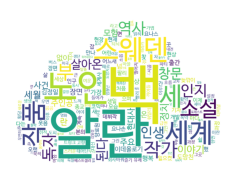

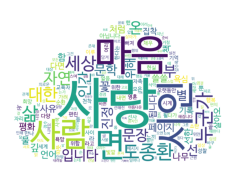

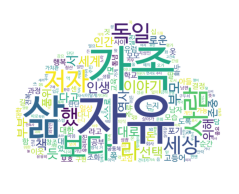

In [ ]:
plt.figure(figsize = (W//10, H//10), facecolor = None)
plt.subplot(2, 1, 1)  
plt.imshow(gen_list[0]) 
plt.axis("off")
plt.tight_layout(pad = 0)
print(word.loc[0][['title','author','categoryName','genres','mood','interest']])

plt.figure(figsize = (W//10, H//10), facecolor = None)
plt.subplot(2, 2, 1)  
plt.imshow(gen_list[1]) 
plt.axis("off")
plt.tight_layout(pad = 0)
print(word.loc[1][['title','author','categoryName','genres','mood','interest']])

plt.figure(figsize = (W//10, H//10), facecolor = None)
plt.subplot(2, 1, 2)  
plt.imshow(gen_list[2]) 
plt.axis("off")
plt.tight_layout(pad = 0)
print(word.loc[2][['title','author','categoryName','genres','mood','interest']])

word[['title','author','categoryName','genres','mood','interest']]

In [ ]:
word.loc[0][['title','author','categoryName','genres','mood','interest']]

title                    창문 넘어 도망친 100세 노인 (리커버)
author                                  요나스 요나손 
categoryName                                  소설
genres                         [역사, 동화, 로맨스, 전쟁]
mood                    [도전, 고민, 후회, 행복, 희망, 불행]
interest        [생각, 시간, 사회, 정치, 인생, 청춘, 사랑, 성공]
Name: 0, dtype: object